In [1]:
import xarray as xr
from glob import glob
import pylab as plt
import pandas as pd
import os
from functools import reduce
import seaborn as sns
import time
import re

from pismragis.analysis import sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_paleo_file, copy_file, nc_add_id
from pismragis.stats import run_stats

In [3]:
data_dir = "/import/c1/ICESHEET/ICESHEET/pism-greenland/paleo/"

grid = 12000
exp = {"Experiment": "climate-calving",
        "proj_dir": "2023_10_climate_calving_w_posterior/",
        "scalar_dir": "scalar",
        "processed_dir": "processed_scalar",
        "fig_dir": "figures",
        "lhs": "gris_paleo_climate_calving_w_posterior_lhs_20",
        "DEM": "GRIMP"
    }

s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
fig_dir = os.path.join(data_dir, exp["proj_dir"], exp["fig_dir"])
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

scalar_files = sorted(glob(os.path.join(s_dir, f"""ts_gris_ext_g{grid}m_*{exp["DEM"]}_id_*.nc""")))
processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])
for scalar_file in scalar_files:
    if check_paleo_file:
        copy_file(scalar_file, processed_path)
processed_files = sorted(glob(os.path.join(processed_path, f"""ts_gris_ext_g{grid}m_*{exp["DEM"]}_id_*.nc""")))



In [8]:
n_jobs = 40

In [4]:
def to_year(x):
    return x.year

In [5]:
def preprocess_nc(ds):
    m_id_re = re.search("id_(.+?)_", ds.encoding["source"])
    ds.expand_dims("id")
    assert m_id_re is not None
    m_id: Union[str, int]
    try:
        m_id = int(m_id_re.group(1))
    except:
        m_id = str(m_id_re.group(1))
    ds["id"] = m_id
    return ds.mean("nv")


In [7]:
ds = xr.open_mfdataset(processed_files, preprocess=preprocess_nc, combine="nested", concat_dim="id", parallel=True)
ds_df = ds.to_dask_dataframe()

In [14]:
fontsize = 8
lw = 0.65
markersize = 1
params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
    }

plt.rcParams.update(params)

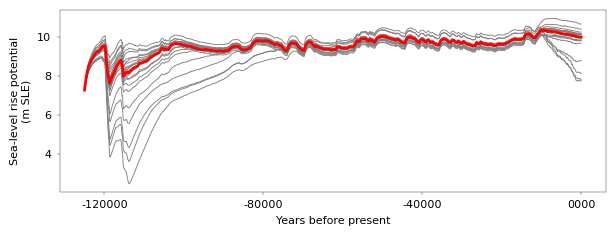

In [15]:
plot_var = "sea_level_rise_potential" 

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
ds[plot_var].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
ds[plot_var].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, f"{plot_var}_paleo-ensemble-{grid}m.pdf"))

In [16]:
sa_ens_ds = ds["sea_level_rise_potential"].resample(time="100AS").mean()

X_df = (
    sa_ens_ds.to_dataframe()
    .reset_index()
    .dropna()
    .sort_values(by=["time", "id"])
    .reset_index(drop=True)
)


In [17]:
uq_file = "../uncertainty_quantification/gris_paleo_climate-calving_w_posterior_lhs_20.csv"
uq_df = pd.read_csv(uq_file)

In [18]:
sa_df = sensitivity_analysis(X_df, ensemble_file=uq_file, n_jobs=n_jobs, calc_variables=["sea_level_rise_potential"])

-------------------------------------------



Processing date: 100%|██████████| 1251/1251 [00:53<00:00, 23.24it/s]


Program finished in 54 seconds


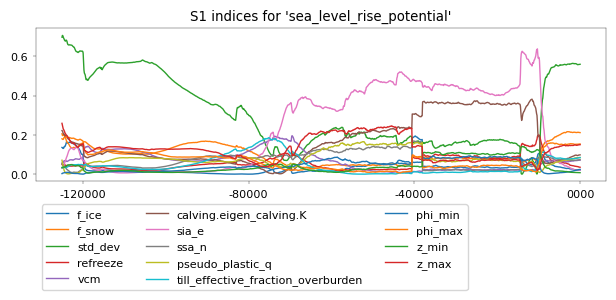

In [19]:
    si = "S1"
    outfile = f"""{si}_paleo_{grid}m.pdf"""
    fig, ax = plt.subplots(
        1,
        1,
        sharex="col",
        figsize=[6.2, 5.6],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["sea_level_rise_potential"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        # [
        #     ax.fill_between(
        #         ds.time,
        #         p_df[v].values - p_conf_df[v].values,
        #         p_df[v].values + p_conf_df[v].values,
        #         alpha=0.2,
        #         lw=0,
        #     )
        #     for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        # ]
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(os.path.join(fig_dir, outfile))


/home/aaschwanden/miniconda3/envs/pism-processing/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


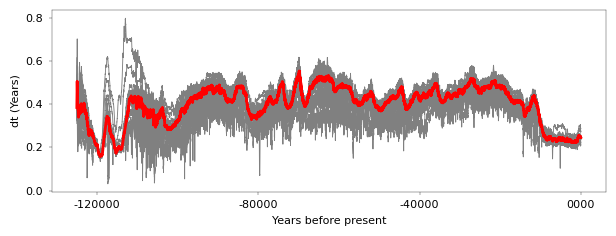

In [20]:
plot_var = "dt"
runmean_100a_ds = ds.rolling(time=100, center=True).mean()

fig = plt.figure(figsize=[6.2, 2.4])
ax = fig.add_subplot(111)
runmean_100a_ds["dt"].plot.line(x="time", color="0.5", ax=ax, add_legend=False)
runmean_100a_ds["dt"].median(dim="id").plot.line(x="time", color="r", lw=2, ax=ax, label="median", add_legend=True)
ax.set_ylabel("dt (Years)")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(f"{plot_var}_paleo-ensemble-12km.pdf")

In [21]:
process_groups = {"Surface": ["f_ice", "f_snow", "std_dev", "refreeze"],
                 "Calving": ["vcm", "calving.eigen_calving.K"],
                 "Ice Flow": ["sia_e", "ssa_n", "pseudo_plastic_q", "till_effective_fraction_overburden", "phi_min", "phi_max", "z_min", "z_max"]
                 }

In [22]:
def merge_by_process(df: pd.DataFrame, p: str):
        df = pd.merge(df[process_groups[p]].sum(axis=1).rename("Si_value"), df[["Date", "Si", "Variable"]], left_index=True, right_index=True)
        df["Process"] = p
        return df

In [23]:
sa_by_process_dfs = [merge_by_process(sa_df, p) for p in process_groups.keys()]
sa_by_process_df = pd.concat(sa_by_process_dfs).reset_index(drop=True)
sa_by_process_df['Year'] = sa_by_process_df['Date'].apply(lambda x: x.year)

In [24]:
ensemble_df = ds["sea_level_rise_potential"].to_dataframe().reset_index()
ensemble_df["Year"] = ensemble_df["time"].apply(lambda x: x.year)

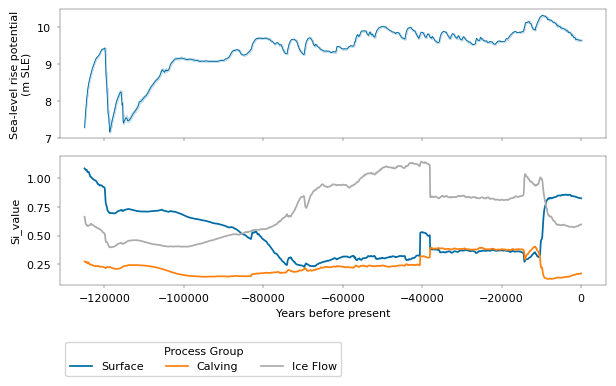

In [35]:
plt.style.use("tableau-colorblind10")

plot_var = "sea_level_rise_potential"

si = "S1"
si_df = sa_by_process_df[sa_by_process_df["Si"] == si]
outfile = f"""{si}_by_process_paleo_g{grid}m.pdf"""
fig, axs = plt.subplots(
    2,
    1,
    sharex="col",
    figsize=[6.2, 4.2],
)
fig.subplots_adjust(bottom=0.0)
ax = axs[0]
sns.lineplot(data=ensemble_df, x="Year", y="sea_level_rise_potential", errorbar=("ci", False), ax=ax, legend=False)
# sns.lineplot(data=ensemble_df, x="Year", y="sea_level_rise_potential", ax=ax, legend=False)
ax.set_ylabel("Sea-level rise potential\n(m SLE)")
ax = axs[1]
sns.lineplot(data=si_df, x="Year", y="Si_value", hue="Process", lw=1.25, ax=ax)
legend = ax.legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75), title="Process Group")
ax.set_xlabel("Years before present")
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, outfile))



In [31]:
ensemble_df["sea_level_rise_potential"].median(axis="time")

ValueError: No axis named time for object type Series

In [32]:
ens_df

NameError: name 'ens_df' is not defined

In [33]:
ensemble_df

,id,time,sea_level_rise_potential,Year
0,0.0,-124999-01-01 00:00:00,7.284659,-124999
1,0.0,-124998-01-01 00:00:00,7.285902,-124998
2,0.0,-124997-01-01 00:00:00,7.287205,-124997
3,0.0,-124996-01-01 00:00:00,7.288614,-124996
4,0.0,-124995-01-01 00:00:00,7.290202,-124995
...,...,...,...,...
2500015,9.0,-0003-01-01 00:00:00,8.120178,-3
2500016,9.0,-0002-01-01 00:00:00,8.119832,-2
2500017,9.0,-0001-01-01 00:00:00,8.119490,-1
2500018,9.0,0000-01-01 00:00:00,8.119118,0
